<a href="https://colab.research.google.com/github/Shuhxian/Face_Mask_Detection/blob/main/Facemask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Shuhxian/Face_Mask_Detection.git
%cd Face_Mask_Detection

Cloning into 'Face_Mask_Detection'...
remote: Enumerating objects: 19306, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 19306 (delta 0), reused 1 (delta 0), pack-reused 19304
Receiving objects: 100% (19306/19306), 5.52 GiB | 43.68 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (19247/19247), done.
/content/Face_Mask_Detection


In [2]:
#Importing libraries
from imutils import paths
import pickle
import os

import cv2 
from PIL import Image
import dlib
from skimage import filters
from skimage.io import imread

import re
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.optimizers import Adam
from keras.models import model_from_json

#Load some pretrained models for face detetcion
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [3]:
def shape_to_normal(shape):
    """
    Reshape the detected face.
    """
    shape_normal = []
    for i in range(0, 5):
        shape_normal.append((i, (shape.part(i).x, shape.part(i).y)))
    return shape_normal

def get_eyes_dlib(shape):
    """
    Get the location of the eyes.
    """
    left_eye_x = int(shape[3][1][0] + shape[2][1][0]) // 2
    left_eye_y = int(shape[3][1][1] + shape[2][1][1]) // 2
    right_eyes_x = int(shape[1][1][0] + shape[0][1][0]) // 2
    right_eyes_y = int(shape[1][1][1] + shape[0][1][1]) // 2
    return (left_eye_x, left_eye_y), (right_eyes_x, right_eyes_y)

def distance(a, b):
    """
    Calculate the distance between two points using pythagoras theorem.
    """
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def imgCropping(img,masked=False,train=True):
  """
  To rotate the face using the position of the eyes and crop the face.
  """
  raw=True #To check if the image can be rotated and cropped correctly or not
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Load the input image and convert it from BGR (OpenCV ordering)
  rects = detector(gray, 0) #Detect the faces in the photo
  for rect in rects:
        raw=False #Face detected
        x = rect.left() 
        y = rect.top()
        w = rect.right()
        h = rect.bottom()
        shape = predictor(gray, rect) #Predict the shape of the face
        shape = shape_to_normal(shape) 
        left_eye, right_eye = get_eyes_dlib(shape) #Get the location of the eyes
        center_of_forehead = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
        center_pred = (int((x + w) / 2), int((y + h) / 2))
        #Get the rotation angle 
        if left_eye[1]<right_eye[1]:
          hyp = distance(left_eye, right_eye)
          adj = distance(left_eye, (left_eye[0],right_eye[1]))
          cos_a=adj/hyp
          angle = 90-np.arccos(cos_a)*180/np.pi
        else:
          hyp = distance(left_eye, right_eye)
          adj = distance(left_eye, (right_eye[0],left_eye[1]))
          cos_a=adj/hyp
          angle = -np.arccos(cos_a)*180/np.pi
        imgArr = Image.fromarray(img)
        imgArr = np.array(imgArr.rotate(angle)) #Rotate the image depending on the location of the eyes
        imgNew = Image.fromarray(imgArr)
        imgNew = imgNew.resize((240,240)) #Resize the image
        imgArr=np.array(imgNew)
        blockSize=24
        imgCrop=imgArr[5*blockSize:,:] #Crop out the lower portion of the face for the mask
        #Save the cropped image.
        path="/content/Face_Mask_Detection/cropped/"
        if masked:
          path="/content/Face_Mask_Detection/cropped_masked/"
        if train:
          num=1
          while os.path.exists(path+str(num)+".jpg"):
            num+=1
          Image.fromarray(imgCrop).save(path+str(num)+".jpg")
        else:
          return imgCrop
  if train==False: #If by any chance the face in the image being tested cannot be detected, crop directly.
      imgNew = Image.fromarray(img)
      imgNew = imgNew.resize((240,240))
      imgArr=np.array(imgNew)
      blockSize=24
      imgCrop=imgArr[5*blockSize:,:]
      return imgCrop

In [17]:
def train():
  """
  Train the model.
  """
  imagePaths = list(paths.list_images('CMFD'))
  # Loop over the properly masked images.
  for (i, imagePath) in enumerate(imagePaths):
      img=cv2.imread(imagePath)
      img=Image.fromarray(img)
      img=img.resize((256,256)) #Resize the image for faster processing
      img.save(imagePath)
      img = cv2.imread(imagePath)
      # Perform face detection.
      bboxes = classifier.detectMultiScale(img)
      # Get bounding box for the detected face.
      for box in bboxes:
        x,y,width,height=box[0],box[1],box[2],box[3]
        img=img[y:y+height,x:x+width]
        break
      img=Image.fromarray(img)
      img.save(imagePath)
      img = cv2.imread(imagePath)
      imgCropping(img,masked=True)

  imagePaths = list(paths.list_images('IMFD'))
  # Loop over the improperly masked images.
  for (i, imagePath) in enumerate(imagePaths):
      img=cv2.imread(imagePath)
      img=Image.fromarray(img)
      img=img.resize((256,256))
      img.save(imagePath)
      img = cv2.imread(imagePath)
      bboxes = classifier.detectMultiScale(img)
      for box in bboxes:
        x,y,width,height=box[0],box[1],box[2],box[3]
        img=img[y:y+height,x:x+width]
        break
      img=Image.fromarray(img)
      img.save(imagePath)
      img = cv2.imread(imagePath)
      imgCropping(img) 

  #Feature Extraction
  X_unmasked=[]
  y_unmasked=[]
  imagePaths = list(paths.list_images('cropped'))
  for imagePath in imagePaths:
    img=imread(imagePath, as_gray=True)
    y_unmasked.append(0)
    pre_hor = filters.prewitt_h(img)
    X_unmasked.append(pre_hor)
  #for i in range(5):
    #plt.imshow(X_unmasked[i],cmap=plt.get_cmap('gray'))
    #plt.show()
  X_masked=[]
  y_masked=[]
  imagePaths = list(paths.list_images('cropped_masked'))
  for imagePath in imagePaths:
    img=imread(imagePath, as_gray=True)
    y_masked.append(1)
    pre_hor = filters.prewitt_h(img)
    X_masked.append(pre_hor)
  #for i in range(5):
    #plt.imshow(X_masked[i],cmap=plt.get_cmap('gray'))
    #plt.show() 

  #Getting the training and testing set
  y_unmasked = np.array(y_unmasked)
  X_unmasked =np.array(X_unmasked).reshape(-1, 120, 240, 1)
  y_masked = np.array(y_masked)
  X_masked =np.array(X_masked).reshape(-1, 120, 240, 1)
  y=np.concatenate((y_unmasked,y_masked),axis=0)
  X=np.concatenate((X_unmasked,X_masked),axis=0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23, shuffle = True)

  #Defining the model
  model = Sequential()
  model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(120,240,1)))
  model.add(MaxPool2D())

  model.add(Conv2D(64, 3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128,activation="relu"))
  model.add(Dense(2, activation="softmax"))

  model.summary()

  opt = Adam(learning_rate=0.00001)
  model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

  #Training the model
  history = model.fit(X_train,y_train,epochs = 25,validation_data = (X_test, y_test))

  #Showing the performance of the model
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(25)

  plt.figure(figsize=(15, 15))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  #Saving the model
  model_json = model.to_json()
  with open("model.json", "w") as json_file:
    json_file.write(model_json)
  model.save_weights("model.h5")
  print("Saved model to disk")

def predict(imagePath,model_json,model_weights):
    """
    Predict whether a face is properly masked or not.
    """
    #Load model
    json_file = open(model_json, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    model.load_weights(model_weights)

    #Load and process the image
    img=imread(imagePath)
    plt.imshow(img)
    plt.show()
    img = cv2.imread(imagePath)
    bboxes = classifier.detectMultiScale(img)
    for box in bboxes:
      x,y,width,height=box[0],box[1],box[2],box[3]
      img=img[y:y+height,x:x+width]
      break
    img=Image.fromarray(img)
    img.save("Testing.jpg")
    img = cv2.imread("Testing.jpg")
    img=imgCropping(img,train=False)
    img=Image.fromarray(img)
    img.save("Testing.jpg")
    img=imread("Testing.jpg", as_gray=True)
    pre_hor = filters.prewitt_h(img)
    X_pred=np.array(pre_hor).reshape(-1, 120, 240, 1)

    #Classify and output the decision
    y_pred=model.predict(X_pred)
    if y_pred[0,0]>y_pred[0,1]:
      print("Entry denied. Please properly wear your mask first.")
    else:
      print("Entry allowed.")

def main():
  print("Welcome. What would you like to do today?")
  while(True):
    print("0-Training; 1-Testing; 2-Exit")
    use=int(input())
    if use==0:
      train()
    elif use==1:
      print("Please select the image that you would like to test.")
      imagePath=input()
      predict(imagePath,"model.json","model.h5")
    else:
      print("Thank you for using our software. See you next time.")
      break

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 120, 240, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 120, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 64)       18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 60, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 60, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


281/281 [==============================] - 9s 30ms/step - loss: 0.4049 - accuracy: 0.8281 - val_loss: 0.1529 - val_accuracy: 0.9452
Epoch 2/50
281/281 [==============================] - 8s 29ms/step - loss: 0.1318 - accuracy: 0.9526 - val_loss: 0.1080 - val_accuracy: 0.9643
Epoch 3/50
281/281 [==============================] - 8s 29ms/step - loss: 0.1014 - accuracy: 0.9629 - val_loss: 0.0877 - val_accuracy: 0.9733
Epoch 4/50
281/281 [==============================] - 8s 29ms/step - loss: 0.0781 - accuracy: 0.9741 - val_loss: 0.0765 - val_accuracy: 0.9750
Epoch 5/50
281/281 [==============================] - 8s 29ms/step - loss: 0.0719 - accuracy: 0.9763 - val_loss: 0.0696 - val_accuracy: 0.9795
Epoch 6/50
281/281 [==============================] - 8s 29ms/step - loss: 0.0571 - accuracy: 0.9801 - val_loss: 0.0633 - val_accuracy: 0.9822
Epoch 7/50
281/281 [==============================] - 8s 29ms/step - loss: 0.0509 - accuracy: 0.9851 - val_loss: 0.0589 - val_accuracy: 0.9826
Epoch 8/50

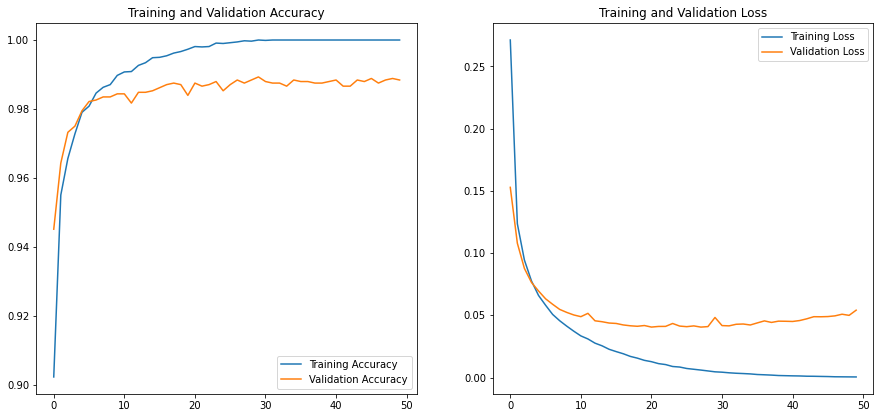

Saved model to disk


In [10]:
main()

Welcome. What would you like to do today?
0-Training; 1-Testing; 2-Exit
1
Please select the image that you would like to test.
Goy_Shuh_Xian_Unmasked.JPG


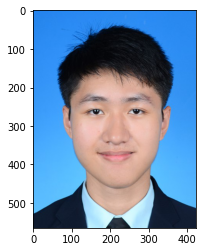

Entry denied. Please properly wear your mask first.
Welcome. What would you like to do today?
0-Training; 1-Testing; 2-Exit
1
Please select the image that you would like to test.
Goy_Shuh_Xian_Masked.jpg


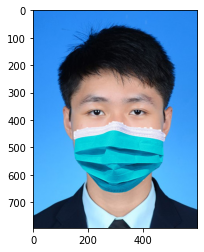

Entry allowed.
Welcome. What would you like to do today?
0-Training; 1-Testing; 2-Exit
2
Thank you for using our software. See you next time.


In [14]:
main()